In [35]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State
from jupyter_dash import JupyterDash
import scipy.stats as ss

import networkx as nx
import numpy as np
import pandas as pd
from tqdm import tqdm

def draw_nx_nodes(g, pos, color_map=None):
    if not color_map is None:
        nx.draw_networkx_nodes(g, pos=pos, node_color=color_map,
                         alpha=0.4, node_size=125)
    else:
        nx.draw_networkx_nodes(g, pos=pos, 
                         alpha=0.4, node_size=125)


def draw_nx_edges(g, pos, dynamic_width=False):
    edges = g.edges()
    nx.draw_networkx_edges(g, pos=pos, alpha=0.1)


def draw_nx_graph(g, dynamic_width=False, color_map = None):
    plt.figure(figsize=(20,12))
    pos = nx.spring_layout(g, seed=1337)
    draw_nx_nodes(g, pos, color_map)
    draw_nx_edges(g, pos, dynamic_width=dynamic_width)
    nx.draw_networkx_labels(g, pos=pos, font_size=10)
    
class NewsGraph():
    def __init__(self, max_time = 20):
        self.groups = 40
        self.student_label_bias = 0
        self.color_map_through_time = []
        self.news_interest_coefficient = 0.8
        self.student_involvment_coefficient = 0.5
        self.time = max_time
        self.edge_trace = None
        self.node_trace = None
        self.computed_time= 10

    def create_graph_nodes(self):
        self.student_label_bias = 0
        self.students_in_each_group = []
        for group in range(self.groups):
            students_count = np.random.randint(10, 20)
            self.students_in_each_group.append(range(self.student_label_bias, self.student_label_bias+students_count))
            self.student_label_bias += students_count


    def create_edges(self):
        self.edges_inside_groups = []
        for group in self.students_in_each_group:
            edge_count = np.random.randint(4*len(group), 5*len(group))
            edges_inside_group = []
            for e in range(edge_count):
                edge = np.random.choice(group, size=2)
                edges_inside_group.append(edge)
            self.edges_inside_groups.append(edges_inside_group)
        self.edges_between_groups = []
        edges_between_groups_count = np.random.randint(100, 150)
        self.all_nodes = range(self.student_label_bias)
        for e in range(edges_between_groups_count):
            edge = np.random.choice(self.all_nodes, size=2)
            self.edges_between_groups.append(edge)
        self.all_edges = self.edges_between_groups.copy()
        for e in self.edges_inside_groups:
            self.all_edges.extend(e)

    def create_graph(self):
        self.G = nx.Graph()
        np.random.seed(42)
        self.create_graph_nodes()
        self.create_edges()

        self.G.add_nodes_from(self.all_nodes)
        self.G.add_edges_from(self.all_edges)
        
    def compute_process(self, free = False, random_person_proba=False, k=1):

        probability = self.student_involvment_coefficient * self.news_interest_coefficient
        start_node = np.random.randint(0, self.student_label_bias-1)

        start_nodes = [start_node]
        nodes = dict()
        used = [0 for node in self.G.nodes()]
        cur_t = 0
        k = 1
        color_map = ['blue' if node != start_node else 'red' for node in self.G]
        self.color_map_through_time = [color_map.copy()]
        if free:
            self.time = self.student_label_bias * 2
        while cur_t < self.time and start_nodes != []:
            neighbors = []
            for start_node in start_nodes: 
                for neighbor in self.G[start_node].keys():
                    if not used[neighbor]:
                        neighbors.append(neighbor)
                
            next_start_nodes = []
            for neighbor in neighbors:
                if ss.binom.rvs(1, probability):
                    next_start_nodes.append(neighbor)
                    color_map[neighbor] = 'red'
            for start_node in start_nodes: 
                if start_node in nodes:
                    if nodes[start_node] != k:
                        nodes[start_node] += 1
                        next_start_nodes.append(start_node)
                    else:
                        used[start_node] = True
                else:
                    nodes[start_node] = 1
            start_nodes = list(set(next_start_nodes)).copy()
            self.color_map_through_time.append(color_map.copy())
            cur_t += 1
        if free:
            self.computed_time = cur_t
    def render_graph(self,time=10, free=False, message_proba=0.5,person_proba=0.5, k=1):
        self.time = time
        self.news_interest_coefficient = message_proba
        self.student_involvment_coefficient = person_proba
        self.compute_process(free=free, k=k)


In [91]:
ng = NewsGraph()
ng.create_graph()
ng.render_graph(free=True)
ng.computed_time

0

In [41]:


graphs = []
proba_message = [0.5]
proba_person = [0.5]
def generate_graph(max_time=20):
    ng = NewsGraph(max_time)
    ng.create_graph()
    G = ng.G

    pos = nx.spring_layout(G, seed=1337)

    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    ng.edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    ng.node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text'
    )

    ng.render_graph(free=True)
    node_adjacencies = []
    node_text = []
    for node, adjacencies in enumerate(G.adjacency()):
        node_adjacencies.append(len(adjacencies[1]))
        node_text.append('# of connections: '+str(node))

    ng.node_trace.marker.color = ng.color_map_through_time[0]
    ng.node_trace.text = node_text
    graphs.append(ng)

    fig = go.Figure(data=[ng.edge_trace, ng.node_trace])
    return fig

max_frames = 11

fig = generate_graph()
app = JupyterDash(__name__)
app.layout = html.Div([
    dcc.Graph(id='graph', figure=fig),
    dcc.Slider(
        id='slider',
        min=1,
        max=11,
        value=1,
        marks={str(step): str(step) for step in range(1, 11)},
        step=None
    ),
    html.H6("Change the value in the text box to see callbacks in action!"),
    html.Div(["Max steps: ",
              dcc.Input(id='time_changer', value='11', type='text')]),
    html.Div(["Coefficient of message passing to new person: ",
              dcc.Input(id='coef1', value='0.5', type='number')]),
    html.Div(["Coefficient of person pass information to another person: ",
              dcc.Input(id='coef2', value='0.5', type='number')]),
    html.Br(),
    html.Button(id='reset', n_clicks=0, children='Compute max time'),
    html.Button(id='rebuild', n_clicks=0, children='New Process'),
    html.Button(id='new_params', n_clicks=0, children='Apply parameters'),
    html.Div(id='output-state'),
    html.Div(id='output-state2'),
    html.Div(id='output-state3')


])
n_clicks_old = [1]

@app.callback(Output('graph', 'figure'),
                [Input('slider', 'value')],
              [Input('rebuild', 'n_clicks')]
             )
def update_output(step, n_clicks):
    ng = graphs[-1]
    if n_clicks != n_clicks_old[-1]:
        n_clicks_old.append(n_clicks)
        ng.render_graph(free=True, message_proba=proba_message[-1], person_proba=proba_person[-1])
    step = min(step, len(ng.color_map_through_time))
    ng.node_trace.marker.color = ng.color_map_through_time[step-1]
    fig = go.Figure(data=[ng.edge_trace, ng.node_trace])
    return fig


@app.callback(Output('output-state', 'children'),
              Output('time_changer', 'value'),
              [Input('reset', 'n_clicks')]
             )
def recompute_max_time(n_clicks):
    ng = graphs[-1]
    return '', len(ng.color_map_through_time)

@app.callback(Output('slider', 'max'),
              Output('slider', 'marks'),
              [Input('time_changer', 'value')]
             )
def resize_slider(new_time):
    new_time = int(new_time if new_time else 1)
    return new_time, {str(step): str(step) for step in range(1, new_time)}


@app.callback(Output('output-state2', 'children'),
              Input('new_params', 'n_clicks'),
              state=[State('coef1', 'value')]
             )
def reset_message_probability(n_clicks, new_proba):
    proba_message.append(float(new_proba))
    return ''

@app.callback(Output('output-state3', 'children'),
              Input('new_params', 'n_clicks'),
              state=[State('coef2', 'value')]
             )
def reset_person_probability(n_clicks, new_proba):
    proba_person.append(float(new_proba))
    return ''
app.run_server(mode='inline',host='127.0.0.1', port=8040, debug=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [02:12<00:00,  1.34s/it]


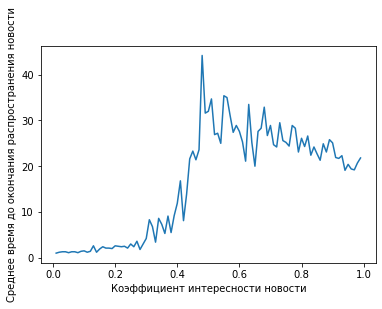

In [37]:
ng = NewsGraph()
ng.create_graph()
time_from_message_proba = []
for proba in tqdm(np.arange(0.01, 1, 0.01)):
    times = []
    for i in range(10):
        ng.render_graph(free=True, message_proba=proba, k=2)
        times.append(ng.computed_time)
    time_from_message_proba.append(np.array(times).mean())

plt.plot(np.arange(0.01, 1, 0.01), time_from_message_proba)
plt.ylabel('Среднее время до окончания распространения новости')
plt.xlabel('Коэффициент интересности новости')
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:43<00:00, 10.39s/it]


Text(0.5, 0, 'Вероятность распространить новость у человека')

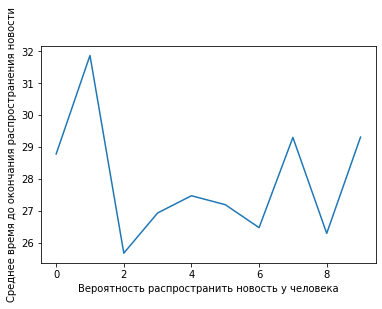

In [42]:
ng = NewsGraph()
ng.create_graph()
time_from_person_proba = []
for k in tqdm(range(10)):
    times = []
    for i in range(100):
        ng.render_graph(free=True, person_proba=0.5, k=k)
        
        times.append(ng.computed_time)
    time_from_person_proba.append(np.array(times).mean())

plt.plot(range(10), time_from_person_proba)
plt.ylabel('Среднее время до окончания распространения новости')
plt.xlabel('Вероятность распространить новость у человека')

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [02:14<00:00,  1.35s/it]


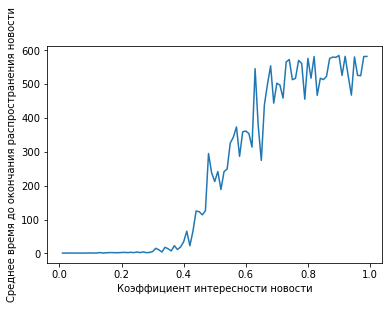

In [44]:
ng = NewsGraph()
ng.create_graph()
time_from_message_proba = []
for proba in tqdm(np.arange(0.01, 1, 0.01)):
    times = []
    for i in range(10):
        ng.render_graph(free=True, message_proba=proba, k=2)
        red_nodes_count = sum([1 if node == 'red' else 0 for node in ng.color_map_through_time[-1]])
        times.append(red_nodes_count)
    time_from_message_proba.append(np.array(times).mean())

plt.plot(np.arange(0.01, 1, 0.01), time_from_message_proba)
plt.ylabel('Среднее время до окончания распространения новости')
plt.xlabel('Коэффициент интересности новости')
plt.show()